In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from datetime import datetime
from sys import maxsize
from scipy.optimize import linprog

### Setup and Classes

In [221]:
df_BOM = pd.DataFrame({
    'operation': ['F.10', 'F.20', 'D.10', 'C.10', 'A.10', 'A.20'],
    'predecessor_operations': [[], ['F.10'], [], ['D.10', 'F.20'], [], ['A.10', 'C.10']],
    'end_product': [0, 0, 0, 0, 0, 1],
    'due_date': [0, 0, 0, 0, 0, 14],
    'processing_time': [2, 3, 3, 1, 5, 2],
    'workcenter': ["WC#2", "WC#1", "WC#1", "WC#1", "WC#1", "WC#2"],
    'machine': ['M1', 'M1', 'M1', 'M1', 'M1', 'M1']
})
display(df_BOM)

df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2"],
    'M1': [1, 1]
})
display(df_machine)

class WorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = id
        self.machines = dict_machines

class Operation:
    def __init__(self, id, processing_time, workcenter, machine, due_date=None, successors=None, predecessors=None):
        self.id = id
        self.successor = successors if successors else None
        self.predecessors = predecessors if predecessors else []

        self.workcenter = workcenter
        self.machine = machine

        self.processing_time = processing_time
        self.start_time = None
        self.end_time = None
        self.due_date = None if due_date != due_date else due_date

        self.scheduled = False

def load_operations_from_df(df, filename=None):

    operations = {}

    for index, row in df.iterrows():
        op = Operation(
            id=str(row['operation']),
            processing_time=row['processing_time'],
            workcenter=row['workcenter'],
            machine=row['machine'],
            due_date=row['due_date'],
            predecessors=row['predecessor_operations']
        )
        operations[op.id] = op

    for index, row in df.iterrows():
        current_op_id = row['operation']
        predecessor_ops = row['predecessor_operations']
        for predecessor in predecessor_ops:
            operations[predecessor].successor = current_op_id
    
    return operations



def load_factory():
    factory = {}
    for idx, row in df_machine.iterrows():
        workcenter = row['workcenter']
        dict_machines = {}
        for machine in (df_machine.columns[1:]): 
            dict_machines[machine] = [[] for _ in range(row[machine])]
        factory[workcenter] = WorkCenter(workcenter, dict_machines=dict_machines)
    return factory 


def load_due_dates(df):
    due_dates = {}
    for idx, row in df.iterrows():
        operation_id = row['operation']
        due_dates[operation_id] = 20 - idx  
    return due_dates

,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,F.10,[],0,0,2,WC#2,M1
1,F.20,[F.10],0,0,3,WC#1,M1
2,D.10,[],0,0,3,WC#1,M1
3,C.10,"[D.10, F.20]",0,0,1,WC#1,M1
4,A.10,[],0,0,5,WC#1,M1
5,A.20,"[A.10, C.10]",1,14,2,WC#2,M1


,workcenter,M1
0,WC#1,1
1,WC#2,1


### Lagrangian Relaxation

In [222]:
def solve_lp_relaxation(c, A_eq, b_eq, A_ineq, b_ineq, lambda_=None):
    if lambda_ is not None:
        lagrangian_c = c + np.dot(lambda_, A_eq)
    else:
        lagrangian_c = c
    result = linprog(lagrangian_c, A_ub=A_ineq, b_ub=b_ineq, A_eq=A_eq, b_eq=b_eq, bounds=(0, None), method='highs')
    return result

def update_multipliers(lambda_, subgradients, step_size):
    lambda_ = lambda_ + step_size * subgradients
    return lambda_

def lagrangian_relaxation(operations, due_dates, factory, max_iterations=1000, tolerance=1e-5):
    n = len(operations)
    c = np.ones(n)
    print(n)
    print(c)
    
    # Initialize equality and inequality constraints 
    A_eq = np.zeros((n, n))
    b_eq = np.zeros(n)
    A_ineq = np.zeros((n, n))
    b_ineq = np.zeros(n)
    
    # Solve LP relaxation
    lp_result = solve_lp_relaxation(c, A_eq, b_eq, A_ineq, b_ineq)
    
    # Initialize Lagrangian multipliers
    lambda_ = np.random.rand(n)
    
    step_size = 1.0
    for iteration in range(max_iterations):
        # Solve the makespan subproblem
        makespan_result = solve_lp_relaxation(c, A_eq, b_eq, A_ineq, b_ineq, lambda_=lambda_)

        # Solve work center subproblems
        for wc in set(op.workcenter for op in operations.values()):
            wc_operations = [op for op in operations.values() if op.workcenter == wc]
            wc_indices = [list(operations.keys()).index(op.id) for op in wc_operations]
            
            wc_A_eq = A_eq[wc_indices][:, wc_indices]
            wc_b_eq = b_eq[wc_indices]
            wc_A_ineq = A_ineq[wc_indices][:, wc_indices]
            wc_b_ineq = b_ineq[wc_indices]
            wc_lambda = lambda_[wc_indices]
            wc_c = c[wc_indices]
            
            wc_result = solve_lp_relaxation(wc_c, wc_A_eq, wc_b_eq, wc_A_ineq, wc_b_ineq, lambda_=wc_lambda)
            
        # Compute subgradients for the work center
            wc_subgradients = wc_b_eq - np.dot(wc_A_eq, wc_result.x)
            wc_lambda = update_multipliers(wc_lambda, wc_subgradients, step_size)
        
        # Compute subgradients for the overall problem
        subgradients = b_eq - np.dot(A_eq, makespan_result.x)
        lambda_ = update_multipliers(lambda_, subgradients, step_size)
        
        # Generate upper and lower bounds (example logic, can be customized)
        upper_bound = np.sum(makespan_result.x)
        lower_bound = np.sum(lp_result.x)
        
        # Update bounds and check stopping criteria
        gap = upper_bound - lower_bound
        if gap < tolerance:
            break
        
        # Update step size 
        step_size *= 0.99
        
    return makespan_result.x



### Scheduling Operations

In [223]:
def schedule_operations(operations, due_dates, factory, operation_times):
    scheduled_operations = []
    sorted_operations = np.argsort(operation_times)
    current_time = 0

    for op_index in sorted_operations:
        op_id = list(operations.keys())[op_index]
        selected_operation = operations[op_id]

        # Ensure predecessors are completed before scheduling
        if selected_operation.predecessors:
            valid_start_times = [
                operations[predecessor].end_time for predecessor in selected_operation.predecessors
                if predecessor in operations and operations[predecessor].end_time is not None
            ]
            if valid_start_times:
                tentative_start_time = max(valid_start_times)
            else:
                continue  # If predecessors are not yet scheduled, skip this operation for now
        else:
            tentative_start_time = current_time

        def check_availability(time, machine_usage):
            start, end = time
            for interval in machine_usage:
                interval_start, interval_end = interval
                if not (end <= interval_start or start >= interval_end):
                    return False
            return True

        def find_latest_start_time(completion_time, processing_time, machine_usage):
            latest_start_time = completion_time - processing_time
            machine_usage = sorted(machine_usage, key=lambda x: x[0])
            for interval in reversed(machine_usage):
                interval_start, interval_end = interval
                if interval_end <= latest_start_time:
                    if check_availability((latest_start_time, latest_start_time + processing_time), machine_usage):
                        return latest_start_time
                latest_start_time = min(latest_start_time, interval_start - processing_time)
            if check_availability((latest_start_time, latest_start_time + processing_time), machine_usage):
                return latest_start_time
            return None

        current_workcenter_id = selected_operation.workcenter
        current_workcenter = factory[current_workcenter_id]
        machine_type = selected_operation.machine
        possible_machines = current_workcenter.machines[machine_type]

        processing_time = selected_operation.processing_time
        tentative_completion_time = tentative_start_time + processing_time
        possible_start_times = []

        for machine_idx, machine_schedule in enumerate(possible_machines):
            if check_availability((tentative_start_time, tentative_completion_time), machine_schedule):
                start_time, end_time = tentative_start_time, tentative_completion_time
            else:
                start_time = find_latest_start_time(tentative_completion_time, processing_time, machine_schedule)
                if start_time is not None:
                    end_time = start_time + processing_time
                else:
                    start_time, end_time = None, None

            if start_time is not None:
                possible_start_times.append((machine_idx, start_time, end_time))

        if not possible_start_times:
            continue  # If no valid start times, skip this operation for now

        selected_machine, finalized_start_time, finalized_end_time = min(possible_start_times, key=lambda x: x[1])
        current_workcenter.machines[machine_type][selected_machine].append((finalized_start_time, finalized_end_time))

        selected_operation.start_time = finalized_start_time
        selected_operation.end_time = finalized_end_time
        selected_operation.scheduled = True
        scheduled_operations.append(selected_operation)

        # Ensure first operation starts at time 0
        if len(scheduled_operations) == 1:
            current_time = finalized_end_time

    # Shift all operations to start at time 0
    min_start_time = min(op.start_time for op in scheduled_operations)
    for op in scheduled_operations:
        op.start_time -= min_start_time
        op.end_time -= min_start_time

    return scheduled_operations





### Plotting Gantt Chart

In [224]:
def plot_gantt_chart(scheduled_operations):
    # Define color mappings
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightpink', 'lightyellow', 'lightgray', 'lightblue', 'lightcyan']
    unique_workcenters = list(set(op.workcenter for op in scheduled_operations))
    workcenter_colors = {}
    for workcenters in range(len(unique_workcenters)):
        workcenter_colors[unique_workcenters[workcenters]] = colors[workcenters % len(colors)]

    fig, ax = plt.subplots(figsize=(14, 8))
    for op in scheduled_operations:
        wc_color = workcenter_colors.get(op.workcenter, 'gray')
        edge_color = 'red' if op.due_date and op.end_time > op.due_date else 'black'
        ax.barh(op.id, op.processing_time, left=op.start_time, color=wc_color, edgecolor=edge_color, linewidth=2)
        ax.text(op.start_time + op.processing_time / 2, op.id, f'{op.machine}: {op.start_time}-{op.end_time}', ha='center', va='center', color='black')

    # Add legend
    workcenter_patches = [mpatches.Patch(color=color, label=wc) for wc, color in workcenter_colors.items()]
    plt.legend(handles=workcenter_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_xlabel('Time')
    ax.set_ylabel('Operations')
    ax.set_title('Gantt Chart for Assembly Scheduling')
    plt.grid(True)
    plt.show()

def plot_gantt_chart_sorted_by_workcenter(scheduled_operations):
    # Define color mappings
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightpink', 'lightyellow', 'lightgray', 'lightblue', 'lightcyan']
    unique_workcenters = list(set(op.workcenter for op in scheduled_operations))
    workcenter_colors = {wc: colors[i % len(colors)] for i, wc in enumerate(unique_workcenters)}

    # Sort operations by workcenter and then by start_time
    sorted_operations = sorted(scheduled_operations, key=lambda x: (x.workcenter, x.machine, x.start_time))

    fig, ax = plt.subplots(figsize=(14, 8))

    # Create a mapping of workcenters and their machines
    y_ticks = []
    y_tick_labels = []
    machine_index = 0
    workcenter_machine_map = {}

    for wc in unique_workcenters:
        machines = list(set(op.machine for op in scheduled_operations if op.workcenter == wc))
        for machine in machines:
            workcenter_machine_map[(wc, machine)] = machine_index
            y_ticks.append(machine_index)
            y_tick_labels.append(f'{wc} - {machine}')
            machine_index += 1

    # Plot the operations
    for op in sorted_operations:
        wc_color = workcenter_colors.get(op.workcenter, 'gray')
        edge_color = 'red' if op.due_date and op.end_time > op.due_date else 'black'
        y_pos = workcenter_machine_map[(op.workcenter, op.machine)]
        ax.barh(y_pos, op.processing_time, left=op.start_time, color=wc_color, edgecolor=edge_color, linewidth=2)
        ax.text(op.start_time + op.processing_time / 2, y_pos, f'{op.id}: {op.start_time}-{op.end_time}', ha='center', va='center', color='black')

    # Add legend
    workcenter_patches = [mpatches.Patch(color=color, label=wc) for wc, color in workcenter_colors.items()]
    plt.legend(handles=workcenter_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_tick_labels)
    ax.set_xlabel('Time')
    ax.set_ylabel('Machines by Workcenter')
    ax.set_title('Gantt Chart for Assembly Scheduling (Sorted by Workcenter)')
    plt.grid(True)




### Test Case #1

In [225]:
df_BOM = pd.DataFrame({
    'operation': ['F.10', 'F.20', 'D.10', 'C.10', 'A.10', 'A.20'],
    'predecessor_operations': [[], ['F.10'], [], ['D.10', 'F.20'], [], ['A.10', 'C.10']],
    'end_product': [0, 0, 0, 0, 0, 1],
    'due_date': [0, 0, 0, 0, 0, 14],
    'processing_time': [2, 3, 3, 1, 5, 2],
    'workcenter': ["WC#2", "WC#1", "WC#1", "WC#1", "WC#1", "WC#2"],
    'machine': ['M1', 'M1', 'M1', 'M1', 'M1', 'M1']
})
display(df_BOM)
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2"],
    'M1': [1, 1]
})
display(df_machine)

,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,F.10,[],0,0,2,WC#2,M1
1,F.20,[F.10],0,0,3,WC#1,M1
2,D.10,[],0,0,3,WC#1,M1
3,C.10,"[D.10, F.20]",0,0,1,WC#1,M1
4,A.10,[],0,0,5,WC#1,M1
5,A.20,"[A.10, C.10]",1,14,2,WC#2,M1


,workcenter,M1
0,WC#1,1
1,WC#2,1


6
[1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0.]


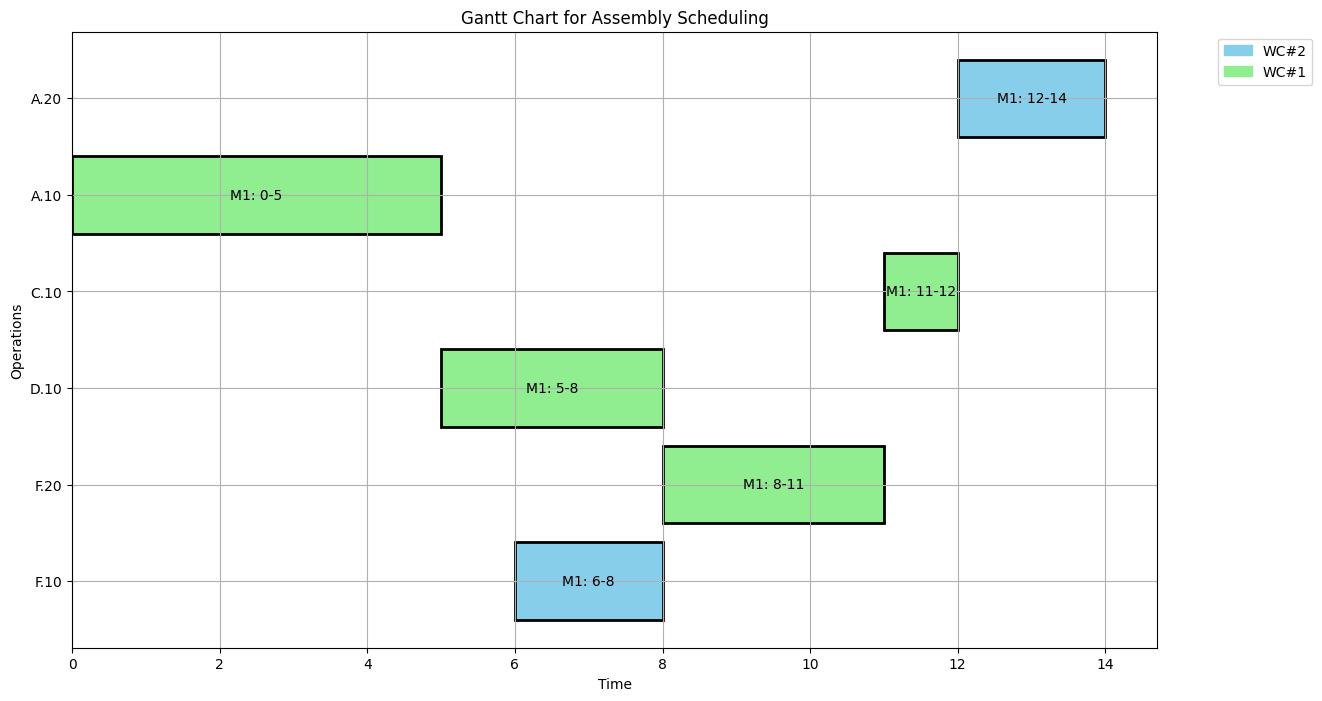

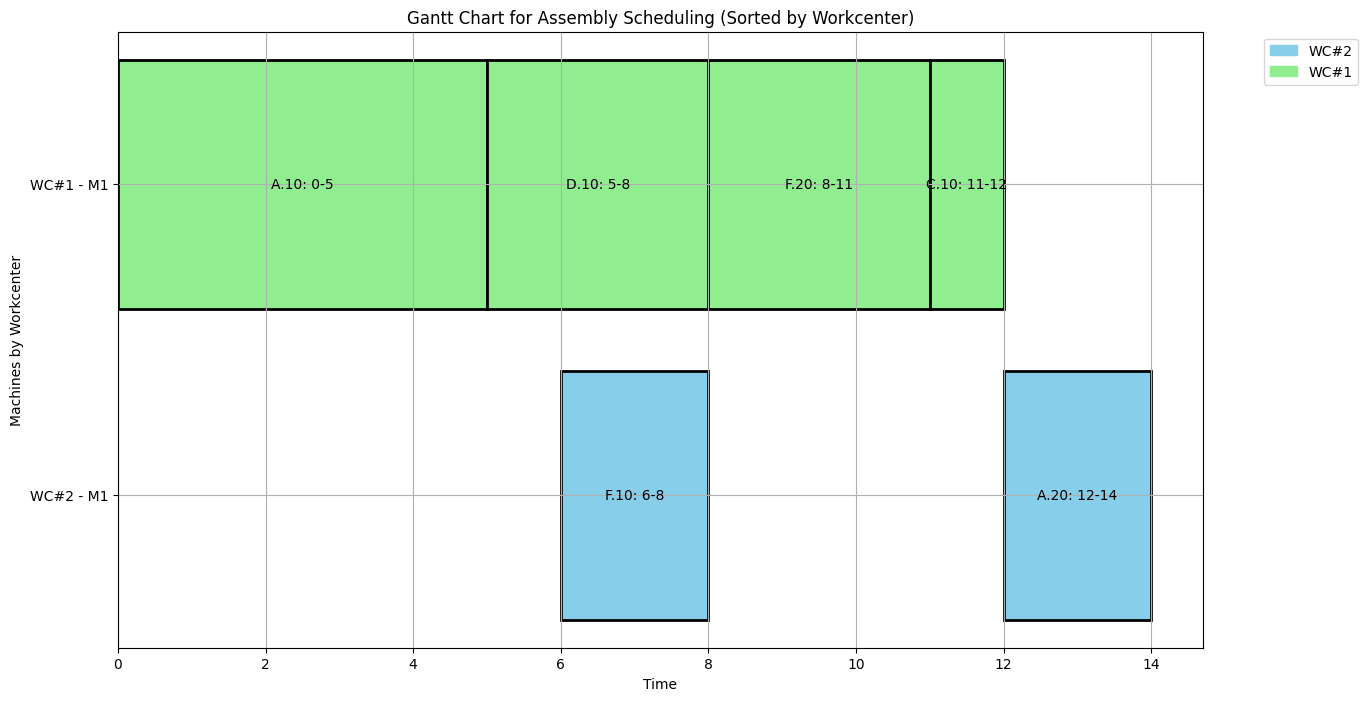

In [226]:
factory = load_factory()
operations = load_operations_from_df(df_BOM)
due_dates = load_due_dates(df_BOM)

operation_times = lagrangian_relaxation(operations, due_dates, factory)
print(operation_times)
scheduled_operations = schedule_operations(operations, due_dates, factory, operation_times)
plot_gantt_chart(scheduled_operations)
plot_gantt_chart_sorted_by_workcenter(scheduled_operations)


### Test Case #2

In [227]:
df_BOM = pd.DataFrame({
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'],
    'predecessor_operations': [[], [], ["A"], ["B"], ["C", "D"], ["E", "G"], ["H"], [], ["F"], [], [], [], ["J", "K", "L"], ["M"], ["N"], [], [], ["P", "Q"], ["R"], ["S", "U"], []],
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
    'due_date': [None, None, None, None, None, None, None, None, 50.0, None, None, None, None, None, 80.0, None, None, None, None, 30.0, None],
    'processing_time': [3, 2, 1, 3, 1, 3, 5, 7, 4, 18, 12, 3, 5, 10, 4, 1, 8, 7, 5, 1, 8],
    'workcenter': ['WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#2', 'WC#3', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#3', 'WC#1'],
    'machine': ["M1", "M2", "M3", "M2", "M4", "M5", "M1", "M2", "M3", "M4", "M5", "M1", "M2", "M3", "M2", "M3", "M4", "M5", "M1", "M4", "M2"]
})
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2", "WC#3"],
    'M1': [3, 2, 3],
    'M2': [2, 1, 2],
    'M3': [1, 2, 1],
    'M4': [1, 1, 1],
    'M5': [1, 2, 3]
})
display(df_BOM)
display(df_machine)


,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,A,[],0,NaN,3,WC#2,M1
1,B,[],0,NaN,2,WC#1,M2
2,C,[A],0,NaN,1,WC#1,M3
3,D,[B],0,NaN,3,WC#2,M2
4,E,"[C, D]",0,NaN,1,WC#2,M4
5,F,"[E, G]",0,NaN,3,WC#2,M5
6,G,[H],0,NaN,5,WC#2,M1
7,H,[],0,NaN,7,WC#3,M2
8,I,[F],1,50.0,4,WC#2,M3
9,J,[],0,NaN,18,WC#1,M4


,workcenter,M1,M2,M3,M4,M5
0,WC#1,3,2,1,1,1
1,WC#2,2,1,2,1,2
2,WC#3,3,2,1,1,3


21
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


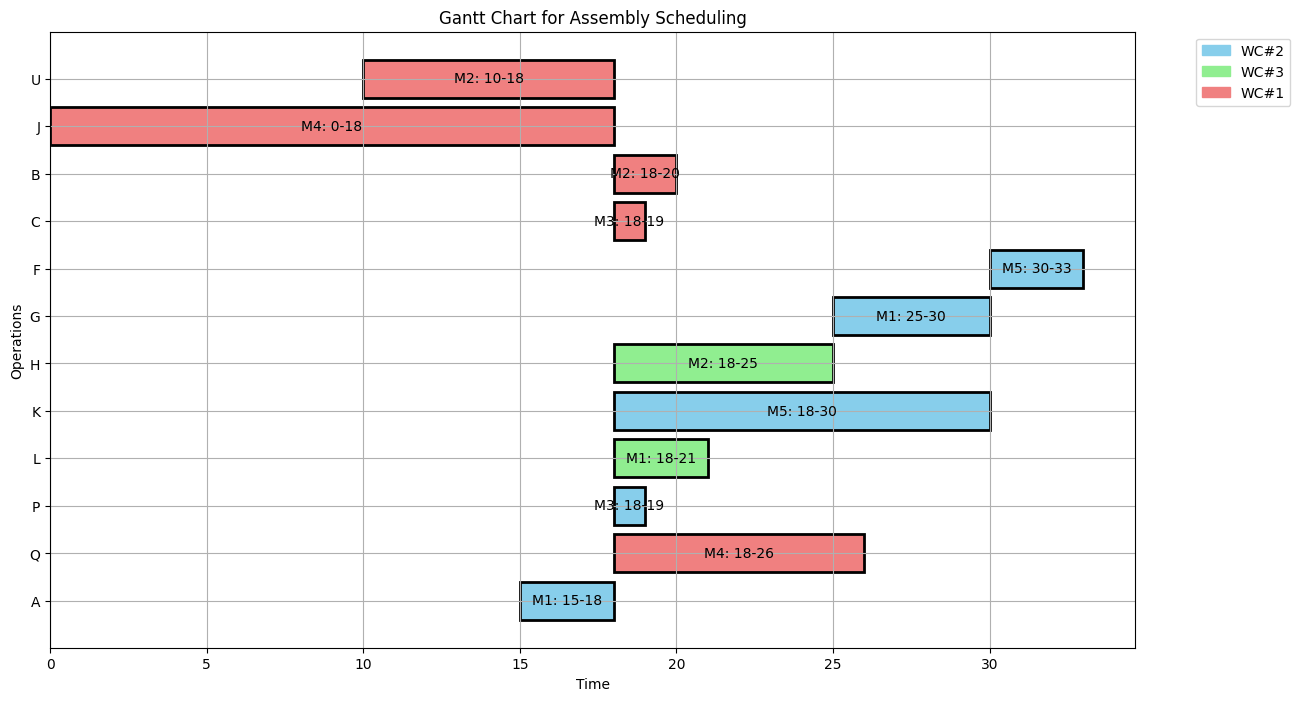

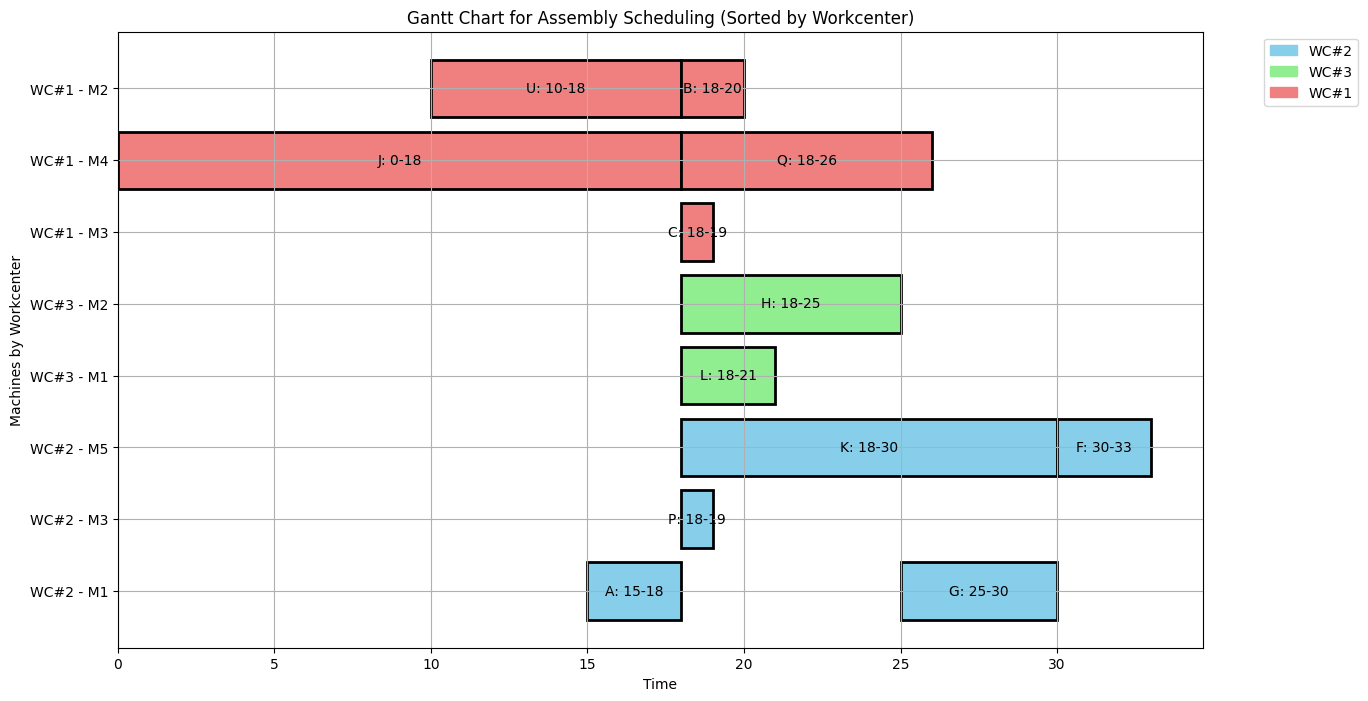

In [228]:
factory = load_factory()
operations = load_operations_from_df(df_BOM)
due_dates = load_due_dates(df_BOM)

operation_times = lagrangian_relaxation(operations, due_dates, factory)
scheduled_operations = schedule_operations(operations, due_dates, factory, operation_times)
plot_gantt_chart(scheduled_operations)
plot_gantt_chart_sorted_by_workcenter(scheduled_operations)

### Test Case #3